### Install Dependencies

In [0]:
!pip install kaggle contractions

     |████████████████████████████████| 317kB 3.9MB/s 
     |████████████████████████████████| 245kB 11.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81706 sha256=bde72bb5cb93d64e64b512b46e39acc85a0a79ca80794c3d958aa7673b5bd378
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


### Import Dependencies

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = 'spyrosmouselinos'
os.environ['KAGGLE_KEY'] = 'a907fb69eab07900ccb6e1f2874fd343'

import re
import contractions
import numpy as np
import pandas as pd

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
from random import choices
import matplotlib.pyplot as plt



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Connect to Kaggle API and download dataset

In [0]:
api = KaggleApi()
api.authenticate()


if not os.path.exists('train.csv'):
    api.competition_download_file('twitter-sentiment-analysis2','train.csv')
    zf = ZipFile('train.csv.zip', 'r')
    zf.extractall('./')
    zf.close()
    os.remove('train.csv.zip')

data = pd.read_csv('train.csv', delimiter=',',  encoding='latin-1')
data.drop(columns='ItemID', inplace=True)

100%|██████████| 3.67M/3.67M [00:00<00:00, 195MB/s]

### Text Preprocessing / Splitting

In [0]:
data['SentimentText'] = data['SentimentText'].str.lower()

In [0]:
def preprocess(sentence):
    # Convert to Lower Case
    sentence = sentence.lower()

    # Replace Contractions
    sentence = contractions.fix(sentence, slang=True)

    # Remove Links
    sentence = re.sub(r'(http|https|www)\S+', ' ', sentence)

    # Remove usernames
    sentence = re.sub(r'@\w+', ' ', sentence)

    # Remove non-word characters
    sentence = re.sub(r'\W', ' ', sentence)

    # Remove underscores 
    sentence = re.sub(r'[-_]', ' ', sentence)

    # Remove numbers
    sentence = re.sub(r'[0-9]', ' ', sentence)
    
    # Remove all single characters
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)

    # Substituting multiple spaces with single space
    sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)

    # Lemmatization
    sentence = sentence.split()

    sentence = [lemmatizer.lemmatize(word) for word in sentence]
    sentence = ' '.join(sentence)
    return sentence

In [0]:
data['SentimentText'] = data['SentimentText'].apply(lambda x : preprocess(x))

In [0]:
### Convert into lists and split
y = data['Sentiment'].values
x = data['SentimentText'].values

In [0]:
x = x.astype('str')

In [0]:
from sklearn.model_selection import train_test_split  
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, shuffle=True, random_state=34)
x_dev, x_test, y_dev, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test, shuffle=True, random_state=34)

In [0]:
len(x_train),len(x_dev),len(x_test)

(69992, 14998, 14999)

### Features 
* TF
* TF-IDF

### Classifiers
* Dummy
* Logistic Regression
* Logistic Regression SGD
* Naive Bayes
* MLP

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, learning_curve, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, classification_report,roc_curve, auc

In [0]:
def show_results(x_train, x_dev, x_test, clf, tfidf):
  x_tr = tfidf.fit_transform(x_train)
  clf.fit(x_tr, y_train)


  x_d = tfidf.transform(x_dev)
  x_t = tfidf.transform(x_test)
  
  print('Train Set')
  predictions_trn = clf.predict(x_tr)
  score_tr = f1_score(y_train, predictions_trn)

  print("train f1-score: %.2f%%"%(score_tr*100))

  print(classification_report(y_train, predictions_trn))
  print()

  print('Development Set')
  predictions_dev = clf.predict(x_d)
  score_dev = f1_score(y_dev, predictions_dev)

  print("dev f1-score: %.2f%%"%(score_dev*100))

  print(classification_report(y_dev, predictions_dev))
  print()

  print('Test Set')
  predictions_test = clf.predict(x_t)
  score_test = f1_score(y_test, predictions_test)

  print("test f1-score: %.2f%%"%(score_test*100))

  print(classification_report(y_test, predictions_test))

  print()
  print('Confusion Matrix')
  print(confusion_matrix(y_test, predictions_test))
  
  return clf , predictions_test

### Dummy Classifier (Input/Tuning is Irrelevant) 

In [0]:
# Make classifier
base = DummyClassifier(strategy='most_frequent')

# Fit on Train Data
base.fit(np.zeros_like(y_train), y_train)

# Make Predictions on Training Set
predictions = base.predict(np.zeros_like(y_train))

score = accuracy_score(y_train, predictions)
print("train accuracy: %.6f%%" % (score*100))

# Make Predictions on Test Set
predictions_base_test = base.predict(np.zeros_like(y_test))
score = accuracy_score(y_test, predictions_base_test)
print("test accuracy: %.6f%%" % (score*100))


print("Test data confusion matrix")
y_true = pd.Series(y_test, name='True')
y_pred = pd.Series(predictions_base_test, name='Predicted')
pd.crosstab(y_true, y_pred)

train accuracy: 56.463596%
test accuracy: 56.463764%
Test data confusion matrix


Predicted,1
True,
0,6530
1,8469


In [0]:
macrof1_tst_bs = f1_score(y_test, predictions_base_test,average="macro")
macrof1_tst_bs

0.3608743821373786

### Logistic Regression

In [0]:
# best_score = 0
# ### Custom GridSearch Loop Implementation
# for min_df in [0.0, 0.1, 10]:
#   for max_df in [0.7, 0.8, 1.0]:
#     for ngram_range in [(1,2), (1,3)]:
#       for use_idf in [True,False]:
#         for C in [1, 0.1, 0.01]:
#           try:
#             tfidf = TfidfVectorizer(min_df = min_df, max_df = max_df, use_idf=use_idf, ngram_range=ngram_range, stop_words=stopwords.words('english'), max_features = 5000, sublinear_tf=True)
#             clf = LogisticRegression(class_weight='balanced', max_iter=10000)

#             x_tr = tfidf.fit_transform(x_train)
#             x_de = tfidf.transform(x_dev)

#             ### Fit Classifier
#             clf.fit(x_tr, y_train)
#             ### Evaluate on Development Set
#             y_pred = clf.predict(x_de)
#             score = f1_score(y_dev, y_pred, average='weighted')
#             # If we got a better score, store the score and parameters
#             if score > best_score:
#                 best_score = score
#                 best_parameters = {'min_df':min_df, 'max_df':max_df, 'ngram_range': ngram_range, 'use_idf':use_idf,'C': C}
#           except:
#             pass

# print("Best score: {:.2f}".format(best_score))
# print("Best parameters: {}".format(best_parameters))

In [0]:
# Results of Grid Search
# Best Score:  0.74{'C': 1.0, 'use_idf': False, 'max_df': 0.7, 'min_df': 0.0, 'vect__ngram_range': (1, 2)}
# Best Params:  

In [0]:
tfidf_lr = TfidfVectorizer(min_df=0.0, max_df=0.7, use_idf=False, ngram_range=(1,2), stop_words=stopwords.words('english'), max_features = 5000, sublinear_tf=True)
clf = LogisticRegression(C=1, class_weight='balanced', max_iter=10000)
clf_lr , predictions_test_lr = show_results(x_train, x_dev, x_test, clf, tfidf_lr)

Train Set
train f1-score: 79.33%
              precision    recall  f1-score   support

           0       0.73      0.75      0.74     30472
           1       0.80      0.78      0.79     39520

    accuracy                           0.77     69992
   macro avg       0.77      0.77      0.77     69992
weighted avg       0.77      0.77      0.77     69992


Development Set
dev f1-score: 77.06%
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      6530
           1       0.78      0.76      0.77      8468

    accuracy                           0.74     14998
   macro avg       0.74      0.74      0.74     14998
weighted avg       0.74      0.74      0.74     14998


Test Set
test f1-score: 76.47%
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      6530
           1       0.77      0.76      0.76      8469

    accuracy                           0.74     14999
   macro avg       0.73  

In [0]:
macrof1_tst_lr = f1_score(y_test, predictions_test_lr,average="macro")
macrof1_tst_lr

0.7339601743522897

### Logistic Regression SGD

In [0]:
# best_score = 0
# ### Custom GridSearch Loop Implementation
# for min_df in [0.0, 0.1]:
#   for max_df in [0.65,0.70]:
#     for ngram_range in [(1,2), (1,3)]:
#       for use_idf in [True, False]:
#         for penalty in ['l1','l2','elasticnet']:
#           for alpha in [0.1, 0.01, 0.0001]:
#             try:
#               tfidf = TfidfVectorizer(min_df=min_df, max_df= max_df, use_idf=use_idf, norm='l2',ngram_range=ngram_range, max_features=5000, stop_words=stopwords.words('english'))
#               clf = SGDClassifier(loss="log", max_iter=10000, class_weight='balanced', early_stopping=True)

#               x_tr = tfidf.fit_transform(x_train)
#               x_de = tfidf.transform(x_dev)

#               ### Fit Classifier
#               clf.fit(x_tr, y_train)
#               ### Evaluate on Development Set
#               y_pred = clf.predict(x_de)
#               score = f1_score(y_dev, y_pred, average='weighted')
#               # If we got a better score, store the score and parameters
#               if score > best_score:
#                   best_score = score
#                   best_parameters = {'min_df':min_df, 'max_df':max_df, 'ngram_range': ngram_range, 'use_idf':use_idf,'alpha': alpha, 'penalty':penalty}
#             except:
#               pass

# print("Best score: {:.2f}".format(best_score))
# print("Best parameters: {}".format(best_parameters))

In [0]:
# Best Score:  0.74
# Best Params:  {'alpha': 0.0001, 'penalty': 'elasticnet', 'use_idf': True, 'max_df': 0.7, 'min_df': 0.0, 'ngram_range': (1, 2)}

In [0]:
tfidf_lr_sgd = TfidfVectorizer(min_df=0.0, max_df=0.7, use_idf=True, ngram_range=(1,2), stop_words=stopwords.words('english'), max_features = 5000, sublinear_tf=True)
clf = SGDClassifier(loss="log", class_weight='balanced', alpha=0.0001, penalty='elasticnet', early_stopping=True, max_iter=10000,random_state=2046)
clf_lr_sgd , predictions_test_lr_sgd = show_results(x_train, x_dev, x_test, clf, tfidf_lr_sgd)

Train Set
train f1-score: 77.21%
              precision    recall  f1-score   support

           0       0.70      0.73      0.72     30472
           1       0.79      0.76      0.77     39520

    accuracy                           0.75     69992
   macro avg       0.74      0.75      0.74     69992
weighted avg       0.75      0.75      0.75     69992


Development Set
dev f1-score: 76.24%
              precision    recall  f1-score   support

           0       0.69      0.72      0.70      6530
           1       0.77      0.75      0.76      8468

    accuracy                           0.74     14998
   macro avg       0.73      0.73      0.73     14998
weighted avg       0.74      0.74      0.74     14998


Test Set
test f1-score: 76.01%
              precision    recall  f1-score   support

           0       0.69      0.72      0.70      6530
           1       0.78      0.74      0.76      8469

    accuracy                           0.73     14999
   macro avg       0.73  

In [0]:
macrof1_tst_lr_sgd = f1_score(y_test, predictions_test_lr_sgd,average="macro")
macrof1_tst_lr_sgd

0.7317006340455614

### Naive Bayes

In [0]:
# best_score = 0
# ### Custom GridSearch Loop Implementation
# for min_df in [0.0, 0.1]:
#   for max_df in [0.65,0.70]:
#     for ngram_range in [(1,2), (1,3)]:
#       for use_idf in [True, False]:
#           for alpha in [1.0, 0.1, 0.01, 0.0001]:
#             try:
#               tfidf = TfidfVectorizer(min_df=min_df, max_df= max_df, use_idf=use_idf,ngram_range=ngram_range, max_features=5000, stop_words=stopwords.words('english'))
#               clf = MultinomialNB(fit_prior=True, alpha=alpha)

#               x_tr = tfidf.fit_transform(x_train)
#               x_de = tfidf.transform(x_dev)

#               ### Fit Classifier
#               clf.fit(x_tr, y_train)
#               ### Evaluate on Development Set
#               y_pred = clf.predict(x_de)
#               score = f1_score(y_dev, y_pred, average='weighted')
#               # If we got a better score, store the score and parameters
#               if score > best_score:
#                   best_score = score
#                   best_parameters = {'min_df':min_df, 'max_df':max_df, 'ngram_range': ngram_range, 'use_idf':use_idf,'alpha': alpha}
#             except:
#               pass

# print("Best score: {:.2f}".format(best_score))
# print("Best parameters: {}".format(best_parameters))

In [0]:
# Best score: 0.74
# Best parameters: {'min_df': 0.0, 'max_df': 0.65, 'ngram_range': (1, 2), 'use_idf': False, 'alpha': 1.0}

In [0]:
tfidf_nb = TfidfVectorizer(min_df=0.0, max_df=0.65, use_idf=False, ngram_range=(1,2), stop_words=stopwords.words('english'), max_features = 5000, sublinear_tf=True)
clf =  MultinomialNB(fit_prior=True, alpha=1.0)
clf_nb , predictions_test_nb = show_results(x_train, x_dev, x_test, clf, tfidf_nb)

Train Set
train f1-score: 80.31%
              precision    recall  f1-score   support

           0       0.77      0.65      0.70     30472
           1       0.76      0.85      0.80     39520

    accuracy                           0.76     69992
   macro avg       0.77      0.75      0.75     69992
weighted avg       0.76      0.76      0.76     69992


Development Set
dev f1-score: 78.63%
              precision    recall  f1-score   support

           0       0.75      0.62      0.68      6530
           1       0.74      0.84      0.79      8468

    accuracy                           0.74     14998
   macro avg       0.74      0.73      0.73     14998
weighted avg       0.74      0.74      0.74     14998


Test Set
test f1-score: 77.95%
              precision    recall  f1-score   support

           0       0.73      0.62      0.67      6530
           1       0.74      0.83      0.78      8469

    accuracy                           0.74     14999
   macro avg       0.74  

In [0]:
macrof1_tst_nb = f1_score(y_test, predictions_test_nb,average="macro")
macrof1_tst_nb

0.7245398616653943

### MLP


In [0]:
# best_score = 0
# best_parameters={}
# ### Custom GridSearch Loop Implementation
# for min_df in [0.0, 0.01]:
#     for ngram_range in [(1,2),(1,3)]:
#           for hidden_layer_size in [(20,20),(30,30),(50,50)]:
#               print('loop1')
#               tfidf = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range, max_features=5000, stop_words=stopwords.words('english'))
#               clf = MLPClassifier(hidden_layer_sizes=hidden_layer_size, solver='adam', early_stopping=True,random_state=3)

#               x_tr = tfidf.fit_transform(x_train)
#               x_de = tfidf.transform(x_dev)

#               ### Fit Classifier
#               clf.fit(x_tr, y_train)
#               ### Evaluate on Development Set
#               y_pred = clf.predict(x_de)
#               score = f1_score(y_dev, y_pred, average='weighted')
#               # If we got a better score, store the score and parameters
#               if score > best_score:
#                   best_score = score
#                   best_parameters = {'min_df':min_df, 'ngram_range': ngram_range, 'hidden_layer_sizes':hidden_layer_size}

# print("Best score: {:.2f}".format(best_score))
# print("Best parameters: {}".format(best_parameters))

In [0]:
# Best score: 0.74
# Best parameters: {'min_df': 0.0, 'ngram_range': (1, 2), 'hidden_layer_sizes': (20, 20)}

In [0]:
tfidf_mlp = TfidfVectorizer(min_df=0, ngram_range=(1,2), stop_words=stopwords.words('english'), max_features = 5000, sublinear_tf=True)
clf= MLPClassifier(solver='adam',hidden_layer_sizes=(20,20),early_stopping=True,random_state=3)
clf_mlp , predictions_test_mlp = show_results(x_train, x_dev, x_test, clf, tfidf_mlp)

Train Set
train f1-score: 80.14%
              precision    recall  f1-score   support

           0       0.75      0.70      0.72     30472
           1       0.78      0.82      0.80     39520

    accuracy                           0.77     69992
   macro avg       0.77      0.76      0.76     69992
weighted avg       0.77      0.77      0.77     69992


Development Set
dev f1-score: 78.00%
              precision    recall  f1-score   support

           0       0.72      0.67      0.70      6530
           1       0.76      0.80      0.78      8468

    accuracy                           0.74     14998
   macro avg       0.74      0.74      0.74     14998
weighted avg       0.74      0.74      0.74     14998


Test Set
test f1-score: 77.39%
              precision    recall  f1-score   support

           0       0.71      0.66      0.69      6530
           1       0.75      0.79      0.77      8469

    accuracy                           0.74     14999
   macro avg       0.73  

In [0]:
macrof1_tst_mlp = f1_score(y_test, predictions_test_mlp,average="macro")
macrof1_tst_mlp

0.7311231794910171

### Bootstraping

In [0]:
#Concatenate x_test and y_test into test set
test=np.concatenate((x_test.reshape(-1,1),y_test.reshape(-1,1)),axis=1)

This part compares the best macro-average score (logistic regression) with the rest of the classifiers

In [0]:
def bootstraping(data, clf1, clf2, tfidf1, tfidf2 ,macrof1_tst1, macrof1_tst2, bins):
    deltas=[]
    observed_delta=macrof1_tst1-macrof1_tst2
    
    for i in range(0,bins):
    
        bootstrap=np.array(choices(data, k=data.shape[0]))
        train_bootstrap=(bootstrap[:,0])
        test_bootstrap=(bootstrap[:,1])

        test_bootstrap=test_bootstrap.astype('int')

        train_bootstrap_lr = tfidf1.transform(train_bootstrap)
        predictions_lr = clf1.predict(train_bootstrap_lr)
        score_lr = f1_score(test_bootstrap,predictions_lr,average="macro")
        
        train_bootstrap_rf = tfidf2.transform(train_bootstrap)
        predictions_rf = clf2.predict(train_bootstrap_rf)
        score_rf = f1_score(test_bootstrap,predictions_rf,average="macro")

        delta=score_lr-score_rf
        deltas.append(1 if delta>=(2*observed_delta) else 0)
        
    pvalue=np.mean(deltas)
    return pvalue

In [0]:
lr_vs_lr_sgd=bootstraping(test, clf_lr, clf_lr_sgd, tfidf_lr, tfidf_lr_sgd, macrof1_tst_lr, macrof1_tst_lr_sgd, 50)
lr_vs_lr_sgd

0.12

In [0]:
lr_vs_nb=bootstraping(test, clf_lr, clf_nb, tfidf_lr, tfidf_nb, macrof1_tst_lr, macrof1_tst_nb, 50)
lr_vs_nb

0.0

In [0]:
lr_vs_mlp=bootstraping(test, clf_lr, clf_mlp, tfidf_lr, tfidf_mlp, macrof1_tst_lr, macrof1_tst_mlp, 50)
lr_vs_mlp

0.1

### ROC CURVES

In [0]:
methods={0:"Logistic Regression", 1:"Logistic Regression with SGD", 2:"Naive Bayes", 3:"MLP"}

In [0]:
fpr = {}
tpr = {}
roc_auc = {}

In [0]:
fpr[0], tpr[0], _ = roc_curve(y_test, clf_lr.predict_proba(tfidf_lr.transform(x_test))[:,1])
roc_auc[0] = auc(fpr[0], tpr[0])

fpr[1], tpr[1], _ = roc_curve(y_test, clf_lr_sgd.predict_proba(tfidf_lr_sgd.transform(x_test))[:,1])
roc_auc[1] = auc(fpr[1], tpr[1])

fpr[2], tpr[2], _ = roc_curve(y_test, clf_nb.predict_proba(tfidf_nb.transform(x_test))[:,1])
roc_auc[2] = auc(fpr[2], tpr[2])

fpr[3], tpr[3], _ = roc_curve(y_test, clf_mlp.predict_proba(tfidf_mlp.transform(x_test))[:,1])
roc_auc[3] = auc(fpr[3], tpr[3])

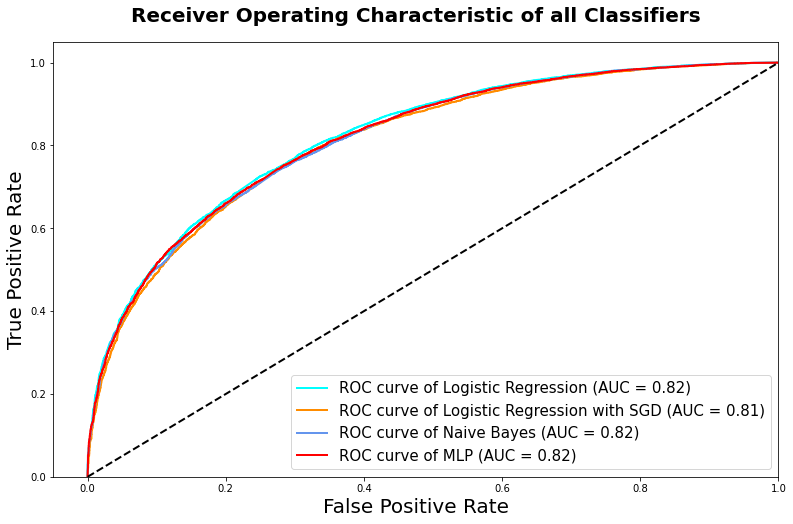

In [0]:
plt.figure(figsize=(13, 8))
lw = 2
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of {methods[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver Operating Characteristic of all Classifiers', pad = 20,fontsize=20,weight="bold")
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

### Learning Curves

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='f1', train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt

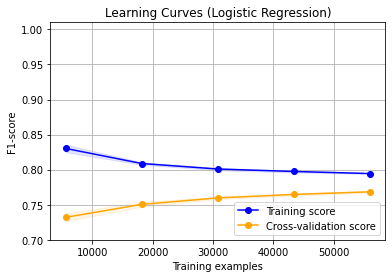

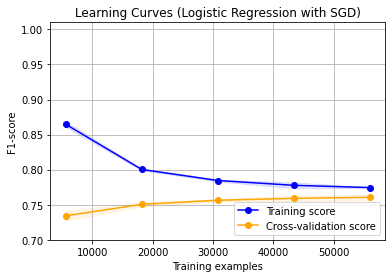

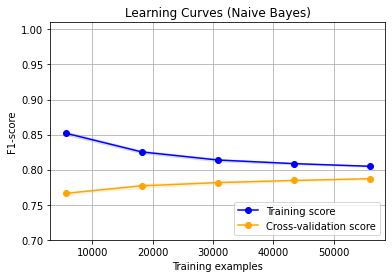

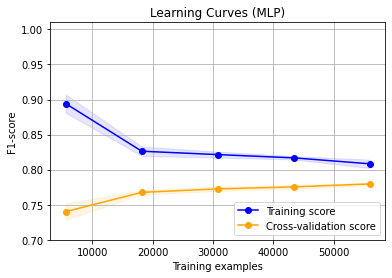

In [0]:
y=y_train
x_tfidf_trn_lr=tfidf_lr.transform(x_train)
x_tfidf_trn_lr_sgd=tfidf_lr_sgd.transform(x_train)
x_tfidf_trn_nb=tfidf_nb.transform(x_train)
x_tfidf_trn_mlp=tfidf_mlp.transform(x_train)

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(clf_lr, title, x_tfidf_trn_lr, y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.show()

title = "Learning Curves (Logistic Regression with SGD)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(clf_lr_sgd, title, x_tfidf_trn_lr_sgd, y, (0.7, 1.01), cv=cv, n_jobs=-1)
plt.show()

title = "Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(clf_nb, title, x_tfidf_trn_nb, y, (0.7, 1.01), cv=cv, n_jobs=-1)
plt.show()

x_tfidf_trn_mlp=tfidf_mlp.transform(x_train)

title = "Learning Curves (MLP)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(clf_mlp, title, x_tfidf_trn_mlp, y, (0.7, 1.01), cv=cv, n_jobs=-1)
plt.show()